In [1]:
import sys
sys.path.append("../../")
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
from DanceProj1.XGB_Genreclass import get_XGBclassifier
from DanceProj1.DanceObj import Dance
from DanceProj1.data_proc import get_data, data_to_features
import matplotlib.pyplot as plt

This notebook is for inspecting the model, focusing on XGBoost, which worked best. get_XGBclassifier essentially does everything from Notebook 02 (see XGB_Genreclass.py)

In [2]:
xgb_mod, X_test, y_test, y_pred, y_proba_pred, yprobdf = get_XGBclassifier()

there were index errors on 0 dances


Having trained on ~1200 Basic sequences and ~100 advanced sequences, XGBoost can perform at about 70%

In [3]:
print('XGBoost Score =',xgb_mod.score(X_test, y_test))

XGBoost Score = 0.7378640776699029


The dataframe yprobdf contains the probability estimates for every sequence in the test set, plus the true label of that sequence

In [4]:
yprobdf.head()

,Ballet Jazz,Break,House,Krump,LAhop,Lock,Midhop,Pop,Street Jazz,Waack,Original Index,True_Label,id
0,0.881912,0.047841,0.000755,0.009659,0.003028,0.039919,0.001684,0.003520,0.009551,0.002129,1202,Ballet Jazz,gJB_sFM_cAll_d07_mJB4_ch05
1,0.872340,0.002356,0.001486,0.005623,0.002907,0.042617,0.002248,0.011095,0.043920,0.015407,1215,Ballet Jazz,gJB_sFM_cAll_d09_mJB2_ch17
2,0.527617,0.005418,0.001452,0.002075,0.002232,0.022762,0.000993,0.005668,0.027847,0.403935,1205,Ballet Jazz,gJB_sFM_cAll_d09_mJB3_ch18
3,0.992875,0.000747,0.000963,0.000064,0.000992,0.000196,0.000848,0.000236,0.001841,0.001240,1209,Ballet Jazz,gJB_sFM_cAll_d07_mJB0_ch01
4,0.647217,0.002038,0.000705,0.002782,0.001083,0.027255,0.001199,0.003232,0.030318,0.284171,1201,Ballet Jazz,gJB_sFM_cAll_d09_mJB1_ch16


In [5]:
genres = yprobdf['True_Label'].unique()
X_truegenre = {}
X_guessgenre = {}
for i, genre in enumerate(genres):
    X_truegenre[genre] = X_test[y_test == i]
    X_guessgenre[genre] = X_test[y_pred == i]


print('number of House pieces, features for each:', X_truegenre['House'].shape)
print('number of House guesses, features for each:', X_guessgenre['House'].shape)

number of House pieces, features for each: (11, 17)
number of House guesses, features for each: (7, 17)


Below is the confusion matrix, which shows the numer of correct classifications for each genre and shows what each genre was misclassified as, on how many occasions

<Figure size 700x700 with 0 Axes>

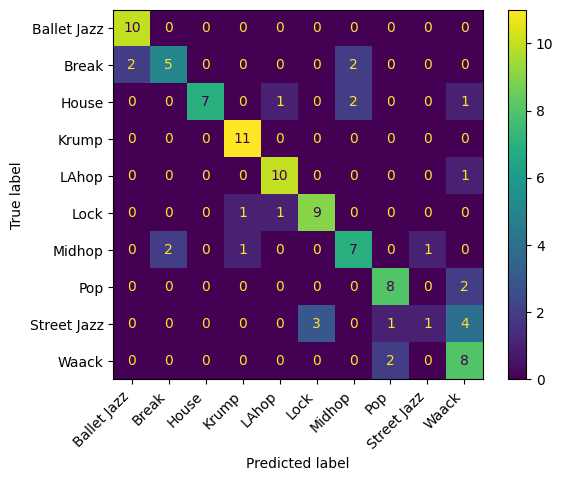

In [6]:
#inspect confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=(7,7))
ConfusionMatrixDisplay.from_estimator(xgb_mod, X_test, y_test)
#change xticks and yticks to labels

labels = yprobdf['True_Label'].unique()
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=labels, rotation=45, ha='right')
plt.yticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=labels)
plt.savefig('../plots/XGBconfusionmatrix.png')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


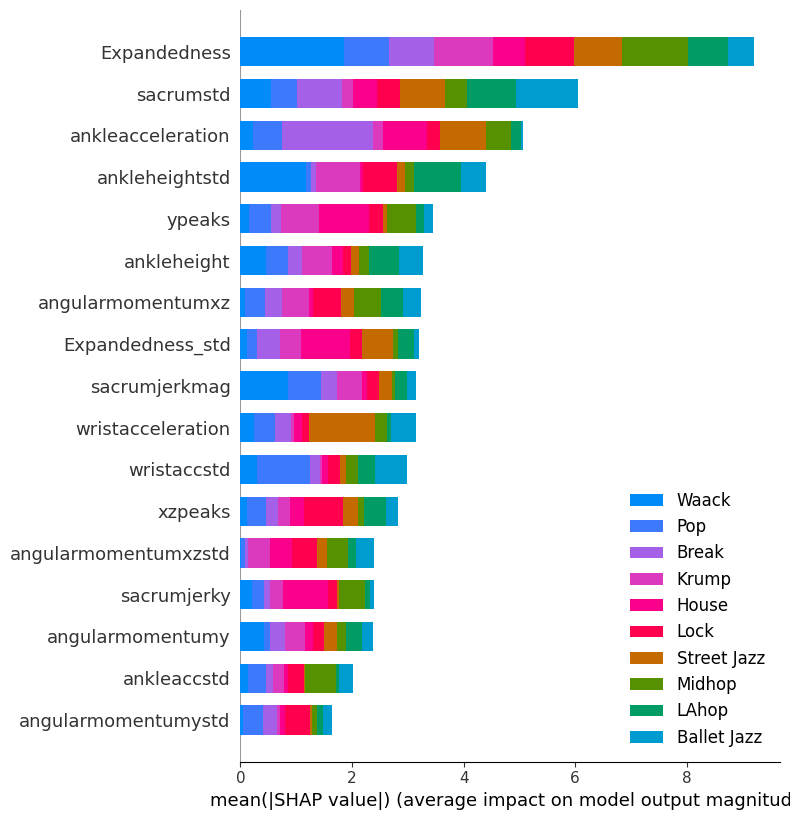

<Figure size 640x480 with 0 Axes>

In [7]:
#shapley
explainer = shap.TreeExplainer(xgb_mod)
shap_values = explainer.shap_values(X_test, y_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=labels, title='Shapley Summary Plot')
plt.savefig('../plots/XGBshapsummaryFull.png')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


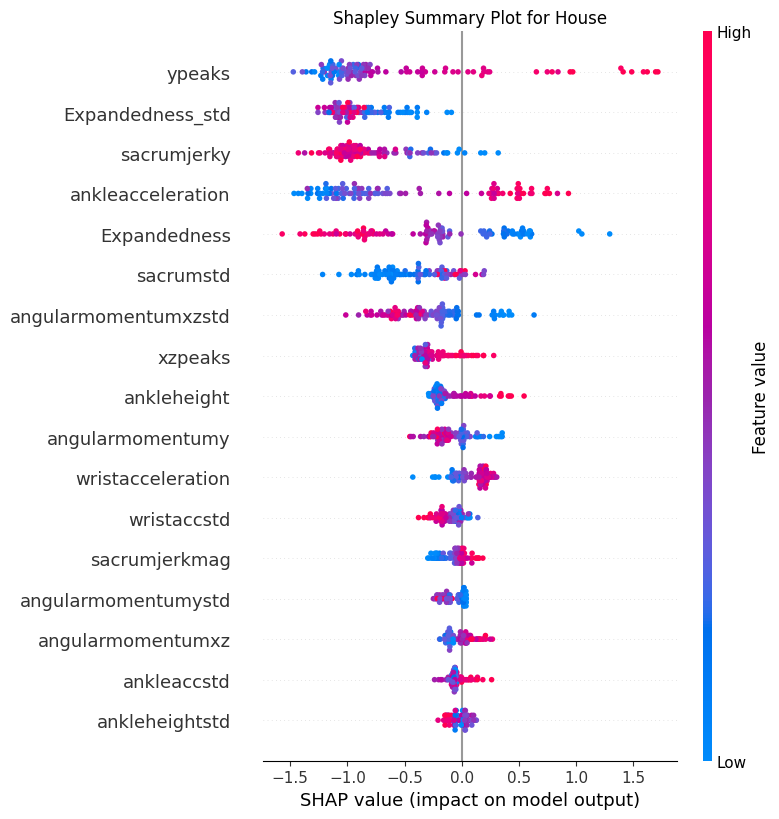

In [16]:
#swarm plot for House
plt.title('Shapley Summary Plot for House')
shap.summary_plot(shap_values[list(genres).index('House')], X_test)


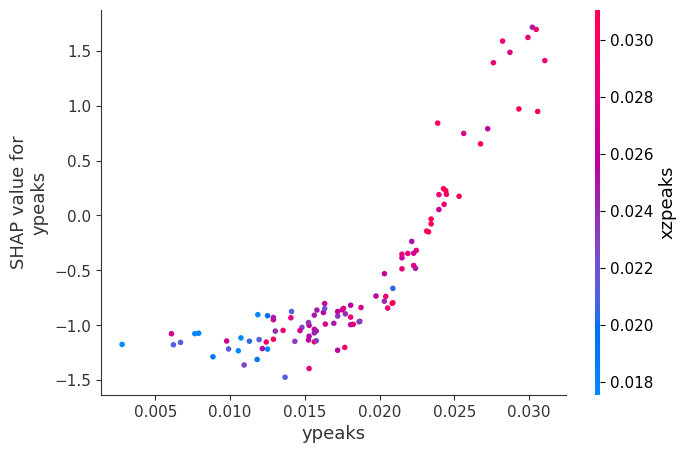

In [17]:
#shape dependence plot, ypeaks House
shap.dependence_plot('ypeaks', shap_values[list(genres).index('House')], X_test, interaction_index='xzpeaks')

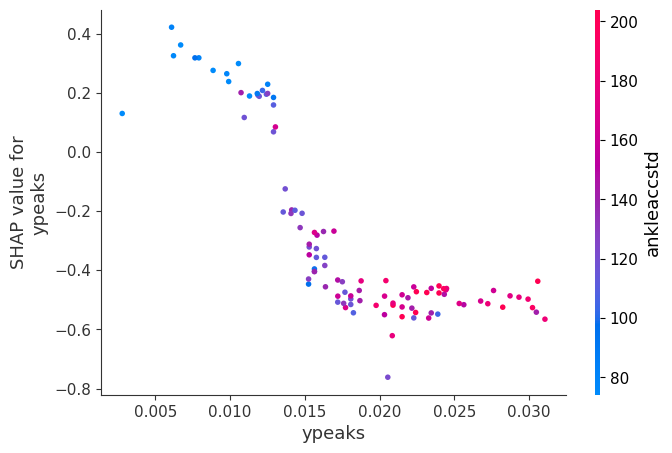

In [19]:
#shape dependence plot, ypeaks House
shap.dependence_plot('ypeaks', shap_values[list(genres).index('Pop')], X_test)

In [19]:
xgb_mod.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
#ok need to go from classes as integers back to classes as strings
#also I can probably remove the y_train and X_train outputs from get_XGBclassifier

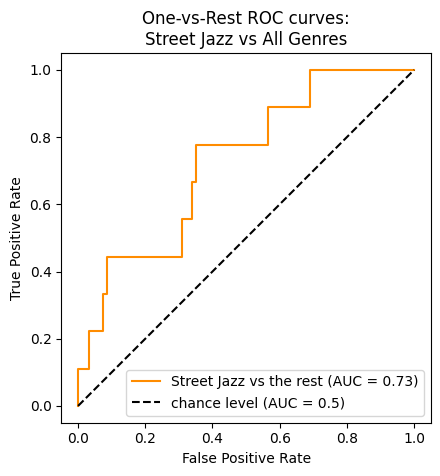

In [13]:
#roc curve, Genre vs all genres
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

genre_mapping = {0: 'Ballet Jazz', 1: 'Break', 2: 'House', 3: 'Krump', 4: 'LAhop', 5: 'Lock', 6: 'Midhop', 7: 'Pop', 8: 'Street Jazz', 9: 'Waack'}

def map_labels_to_genres(labels, mapping):
    return [mapping[label] for label in labels]

# Transform the y_test labels back to genre names
y_test_genres = map_labels_to_genres(y_test, genre_mapping)

# Use the genre names with the LabelBinarizer
label_binarizer = LabelBinarizer().fit(list(genre_mapping.values()))
y_onehot_test = label_binarizer.transform(y_test_genres)

class_of_interest = "Street Jazz"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_proba_pred[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nStreet Jazz vs All Genres")
plt.legend()
plt.show()

In [ ]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
inds = shap.approximate_interactions("Expandedness", shap_values[list(genres).index('House')], X_test)

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot("Age", shap_values, X_test, interaction_index=inds[i])

In [7]:
#show permutation importance
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(xgb_mod, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())



Weight,Feature
0.2233 ± 0.0614,Expandedness
0.0680 ± 0.0246,contraspace
0.0427 ± 0.0291,ypeaks
0.0408 ± 0.0190,wristaccstd
0.0291 ± 0.0174,Expandednessvel
0.0252 ± 0.0315,xzpeaks
0.0175 ± 0.0145,angularmomentumystd
0.0155 ± 0.0095,angularmomentumnosestd
0.0155 ± 0.0418,ankleheightstd
0.0136 ± 0.0095,anklespaceaccstd


In [8]:
#label list for convience 
labels = yprobdf['True_Label'].unique()

Look at how much the features mattered. Below are plots of the top 20, measured by weight, gain, and cover. (Here is one decription of these - https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)

<Figure size 1000x1000 with 0 Axes>

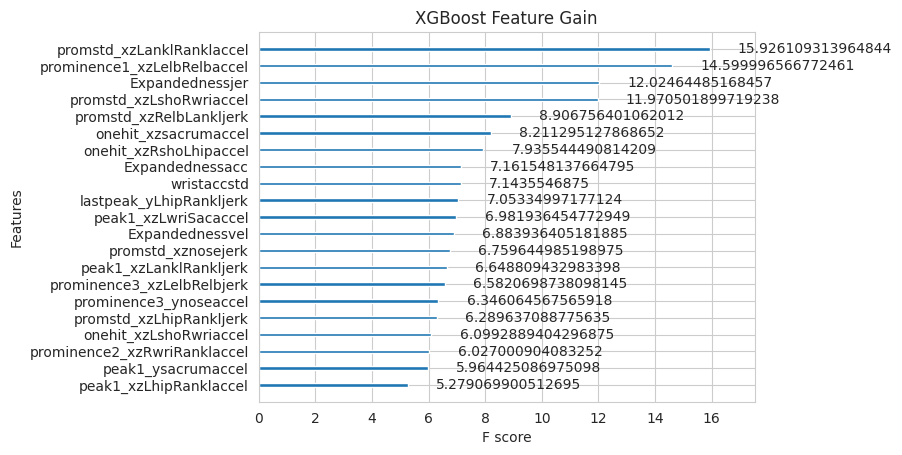

<Figure size 640x480 with 0 Axes>

In [11]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
xgb.plot_importance(xgb_mod, max_num_features=21, importance_type='gain')
plt.title('XGBoost Feature Gain')
plt.show()
plt.savefig('XGBfeaturegain.png')


<Figure size 1000x1000 with 0 Axes>

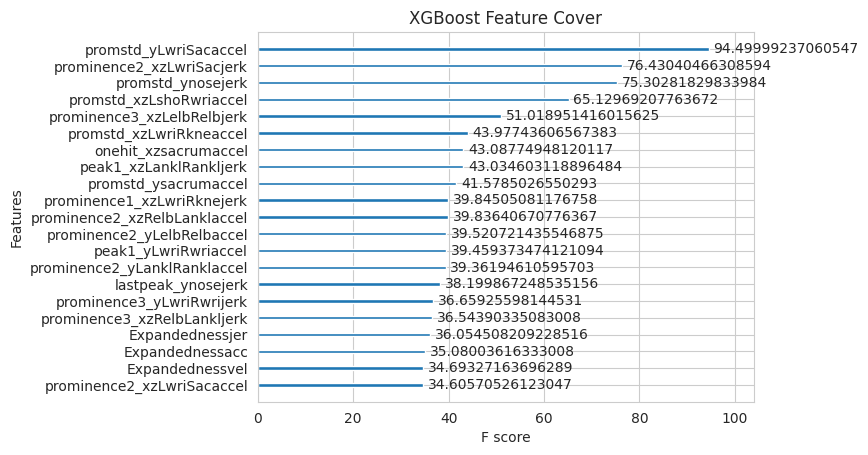

<Figure size 640x480 with 0 Axes>

In [10]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
xgb.plot_importance(xgb_mod, max_num_features=21, importance_type='cover')
plt.title('XGBoost Feature Cover')
plt.show()
plt.savefig('../plots/XGBfeaturecover.png')


<Figure size 1000x1000 with 0 Axes>

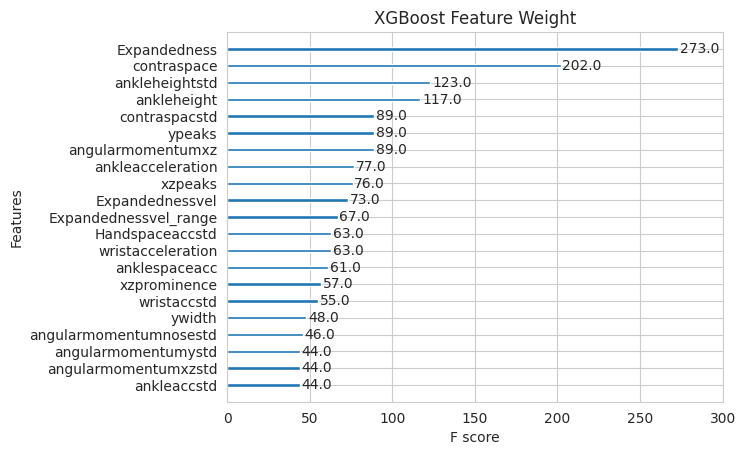

<Figure size 640x480 with 0 Axes>

In [9]:
#check features importance of top 21 features
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
xgb.plot_importance(xgb_mod, max_num_features=21, importance_type='weight')
plt.title('XGBoost Feature Weight')
plt.show()
plt.savefig('../plots/XGBfeatureweight.png')


Get Dataframes of the features of all dances in the test set

In [13]:
aistpath = '../../aist_keypoints'      #path to 3d keypoints data
dataBM, dataFM = get_data(aistpath)    #get data
dfBasic, dfAdvanced = data_to_features(dataBM, dataFM)  #get features

#alphabetize dfs by genre (to avoid reordering by classifiers later)
dfAdvanced = dfAdvanced.sort_values(by='Genre')

#make new indexes for Advanced, starting after last index in Basic, for unique index per id
#this is so that Basic and Adv indexes dont overlap.
dfAdvanced.index = range(len(dfBasic.index), len(dfBasic.index)+len(dfAdvanced.index))

there were index errors on 0 dances


In [46]:
dfAdvanced.head()

,Expandedness,Expandedness_std,Expandednessvel,Expandednessvel_std,Expandednessacc,Expandednessacc_std,Asym_RL_vel,Asym_RL_acc,Asym_RL_jer,Asym_RL_vel_std,...,Contracorr_Relb_Lknee_prominencej2,Contracorr_Relb_Lknee_prominencej3,Contracorr_Relb_Lknee_prominencej_std,Contracorr_Lelb_Rknee_heightjer,Contracorr_Lelb_Rknee_prominencej1,Contracorr_Lelb_Rknee_prominencej2,Contracorr_Lelb_Rknee_prominencej3,Contracorr_Lelb_Rknee_prominencej_std,id,Genre
1394,969.542085,98.855743,992.554874,329.221881,5066.963329,1481.952915,1186.902288,593.157740,1642.836948,9.656070,...,5.548718e+08,5.136387e+08,2.247123e+07,2.008864e+08,3.939626e+08,3.743875e+08,3.587747e+08,1.439571e+07,gWA_sFM_cAll_d25_mWA4_ch05,Waack
1395,928.198813,70.543630,919.877078,454.423360,4635.536604,2239.743494,5305.262381,1786.385563,508.076550,11.420752,...,4.259998e+08,3.933554e+08,6.320765e+07,4.347574e+07,6.279022e+08,5.793772e+08,4.710065e+08,6.558724e+07,gWA_sFM_cAll_d26_mWA3_ch14,Waack
1396,939.923978,68.239028,818.119115,372.186346,4164.762921,1884.353540,1088.842497,-11746.619719,10268.622584,5.731486,...,4.018333e+08,3.521439e+08,4.207317e+07,3.893858e+08,6.366089e+08,3.988821e+08,3.756609e+08,1.179205e+08,gWA_sFM_cAll_d27_mWA3_ch18,Waack
1397,996.041489,79.875845,1124.658078,501.066495,5702.299856,2560.830403,-1896.720798,547.698868,5561.120142,14.036626,...,8.163855e+08,7.443944e+08,6.045825e+07,1.755741e+08,8.769213e+08,7.280281e+08,5.528690e+08,1.324386e+08,gWA_sFM_cAll_d27_mWA5_ch20,Waack
1398,972.235847,83.451521,934.198651,332.413523,4702.131607,1563.975658,1113.834141,-270.571130,1136.730006,4.778593,...,5.548580e+08,5.339156e+08,1.878069e+07,1.540949e+08,5.286268e+08,5.230028e+08,4.677556e+08,2.746552e+07,gWA_sFM_cAll_d25_mWA2_ch03,Waack


In [63]:
ExpandednessADV = dfAdvanced[['Expandedness', 'Genre']]
#ExpandednessADV.head()
#use indeces from X_test to get the same rows as X_test
ExpandednessADV_test = ExpandednessADV.loc[X_test.index]
ExpandednessADV_test.head()

,Expandedness,Genre
1202,986.565303,Ballet Jazz
1215,952.230629,Ballet Jazz
1205,932.590413,Ballet Jazz
1209,993.748996,Ballet Jazz
1201,952.453800,Ballet Jazz


Get a dataframe / matrix where rows = 104 features and columns = genre, values are average of each feature by genre

In [12]:
featuresdf = pd.DataFrame(columns=dfAdvanced['Genre'].unique(), index=X_test.columns)
for i, feature in enumerate(X_test.columns):
    for genre in dfAdvanced['Genre'].unique():
        featuresdf.iloc[i][genre] = dfAdvanced[feature][dfAdvanced['Genre']==genre].mean()
    

featuresdf.head()

NameError: name 'dfAdvanced' is not defined

In [11]:
#  z scale columns of featuresdf
featuresdf_norm = featuresdf.to_numpy()
for i in range(len(featuresdf_norm)):
    featuresdf_norm[i] = (featuresdf_norm[i] - featuresdf_norm[i].mean())/featuresdf_norm[i].std()

featuresdf_norm = pd.DataFrame(featuresdf_norm, columns=featuresdf.columns, index=featuresdf.index)
featuresdf_norm.head()

NameError: name 'featuresdf' is not defined

In [16]:
#probably just order by importance and drop the feature labels

In [10]:
#bar plot of Waack, normalized features values 
sns.set_style('whitegrid')
plt.figure(figsize=(5,5))
sns.barplot(data=featuresdf_norm, x=featuresdf_norm.index, y='Waack')
#make xticks go away
plt.xticks([])
plt.title('Waack Features')
plt.savefig('../plots/feature_plots/Waackfeatures.png')
plt.show()


NameError: name 'featuresdf_norm' is not defined

<Figure size 500x500 with 0 Axes>

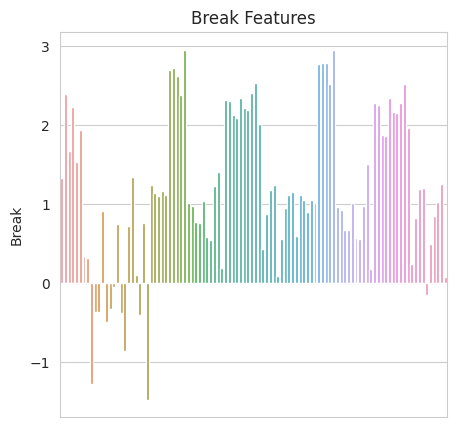

In [83]:
#bar plot of Break, normalized features values 
sns.set_style('whitegrid')
plt.figure(figsize=(5,5))
sns.barplot(data=featuresdf_norm, x=featuresdf_norm.index, y='Break')
plt.xticks([])
plt.title('Break Features')
plt.savefig('../plots/feature_plots/Breakfeatures.png')
plt.show()

In [94]:
genresbyfeatures = featuresdf_norm.to_numpy().T
genresbyfeatures = pd.DataFrame(genresbyfeatures, columns=featuresdf_norm.index, index=featuresdf_norm.columns)
genresbyfeatures.head()

,Expandedness,Expandedness_std,Expandednessvel,Expandednessvel_std,Expandednessacc,Expandednessacc_std,Asym_RL_vel,Asym_RL_acc,Asym_RL_jer,Asym_RL_vel_std,...,Contracorr_Relb_Lknee_height_jer,Contracorr_Relb_Lknee_prominencej1,Contracorr_Relb_Lknee_prominencej2,Contracorr_Relb_Lknee_prominencej3,Contracorr_Relb_Lknee_prominencej_std,Contracorr_Lelb_Rknee_heightjer,Contracorr_Lelb_Rknee_prominencej1,Contracorr_Lelb_Rknee_prominencej2,Contracorr_Lelb_Rknee_prominencej3,Contracorr_Lelb_Rknee_prominencej_std
Ballet Jazz,0.009494,0.347248,0.682272,0.797024,0.54895,1.247109,0.343075,0.574656,-0.011944,-0.360447,...,1.308559,1.448482,1.381002,1.279966,0.935691,2.272577,2.027366,1.871658,1.594402,2.549947
Break,1.327999,2.397934,1.668951,2.228933,1.536036,1.939972,0.341004,0.320396,-1.273239,-0.373508,...,0.236969,0.825718,1.19422,1.199374,-0.146501,0.495209,0.850035,1.029269,1.255092,0.0726
House,-0.628116,-0.466014,0.920576,0.153607,0.958245,0.211995,0.330768,0.428535,-0.998458,-0.373204,...,0.496885,0.446597,0.373273,0.436822,0.24364,0.81573,0.630683,0.607778,0.645561,0.595292
Krump,1.481346,-0.153646,0.404675,0.579736,0.477088,0.563549,0.319888,0.303352,2.221626,-0.318333,...,-0.309724,-0.033035,0.181134,0.28261,-0.489627,-0.129173,-0.018954,0.029589,0.066302,-0.170305
LAhop,-0.341774,-0.663285,-0.503159,-0.930612,-0.43735,-0.918442,0.329094,0.113674,0.673406,-0.364582,...,-0.902845,-0.817074,-0.694805,-0.596226,-0.698174,-0.668278,-0.630992,-0.706079,-0.715305,-0.424022


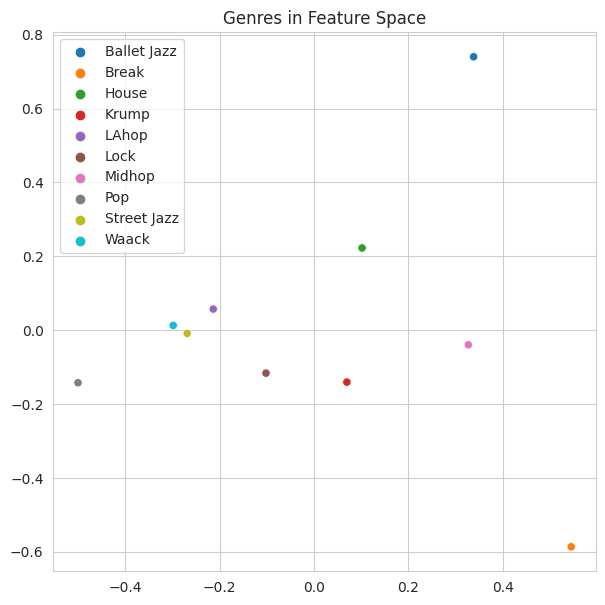

In [95]:
from sklearn.utils.extmath import randomized_svd
X = genresbyfeatures.to_numpy().astype(float)
U, Sigma, VT = randomized_svd(X, n_components=2, n_iter=5, random_state=None)

#plot genres in the 2d feature space
sns.set_style('whitegrid')
plt.figure(figsize=(7,7))
sns.scatterplot(data=genresbyfeatures, x=U[:,0], y=U[:,1], hue=genresbyfeatures.index)
plt.title('Genres in Feature Space')
plt.savefig('../plots/featurespace.png')
plt.show()

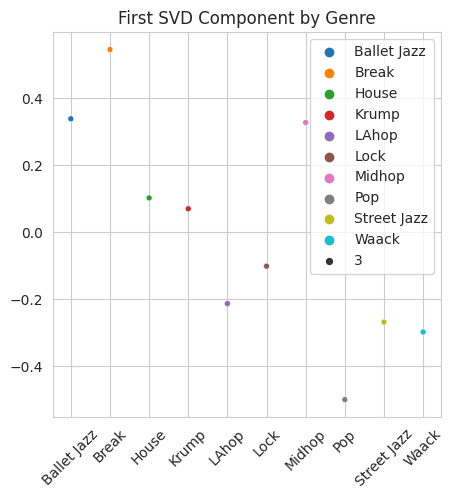

In [100]:
#scatter plot of first SVD component on y axis, dance genre on X axis
sns.set_style('whitegrid')
plt.figure(figsize=(5,5))
sns.scatterplot(data=genresbyfeatures, x=genresbyfeatures.index, y=U[:,0], hue=genresbyfeatures.index, size=3)
plt.title('First SVD Component by Genre')
plt.xticks(rotation=45)
plt.savefig('../plots/firstSVD.png')
plt.show()

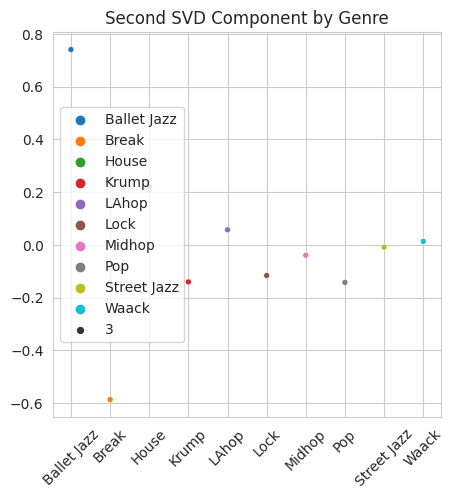

In [99]:
#scatter plot of second SVD component on y axis, dance genre on X axis
sns.set_style('whitegrid')
plt.figure(figsize=(5,5))
sns.scatterplot(data=genresbyfeatures, x=genresbyfeatures.index, y=U[:,1], hue=genresbyfeatures.index, size=3)
plt.xticks(rotation=45)
plt.title('Second SVD Component by Genre')
plt.savefig('../plots/secondSVD.png')
plt.show()

Old stuff below here

In [ ]:
#inspect the misclassified Ballet Jazz pieces
yprob_misBJazz = BJazzdf[BJazzdf['Ballet Jazz']<0.5]
yprob_misBJazz

,Ballet Jazz,Break,House,Krump,LAhop,Lock,Midhop,Pop,Street Jazz,Waack,Original Index,True_Label,id
0,0.102943,0.155679,0.018298,0.104901,0.062415,0.314966,0.030880,0.015018,0.108549,0.086350,1565,Ballet Jazz,gJB_sFM_cAll_d07_mJB4_ch05
1,0.033570,0.023562,0.024930,0.086090,0.024906,0.672489,0.022066,0.014703,0.074809,0.022876,1591,Ballet Jazz,gJB_sFM_cAll_d09_mJB2_ch17
2,0.052050,0.021557,0.007512,0.013277,0.032721,0.623952,0.007026,0.012608,0.022553,0.206744,1571,Ballet Jazz,gJB_sFM_cAll_d09_mJB3_ch18
6,0.079782,0.294858,0.144204,0.030350,0.121908,0.044607,0.041026,0.014055,0.115876,0.113333,1567,Ballet Jazz,gJB_sFM_cAll_d08_mJB0_ch08


In [ ]:
#Create Dance object for Ballet Jazz pieces that were correctly, and incorrectly classified
HitBJazz = []
for data in dataFM['Ballet Jazz']:
    if data[-1] in BJazzdf[BJazzdf['Ballet Jazz']>0.5].values:
        HitBJazz.append(Dance(data[0],dt=1/60))
        HitBJazz[-1].get_features()

print(len(HitBJazz)) 

#get Dance object for all Ballet Jazz pieces that were misclassified
missBJazz = []
for data in dataFM['Ballet Jazz']:
    if data[-1] in yprob_misBJazz.id.values:
        print(data[-1])
        missBJazz.append(Dance(data[0], dt=1/60))
        missBJazz[-1].get_features()

print(len(missBJazz))
print(missBJazz[0])
print(missBJazz[0].acceleration.shape)

6
gJB_sFM_cAll_d07_mJB4_ch05
gJB_sFM_cAll_d08_mJB0_ch08
gJB_sFM_cAll_d09_mJB3_ch18
gJB_sFM_cAll_d09_mJB2_ch17
4
(15, 1919, 3)


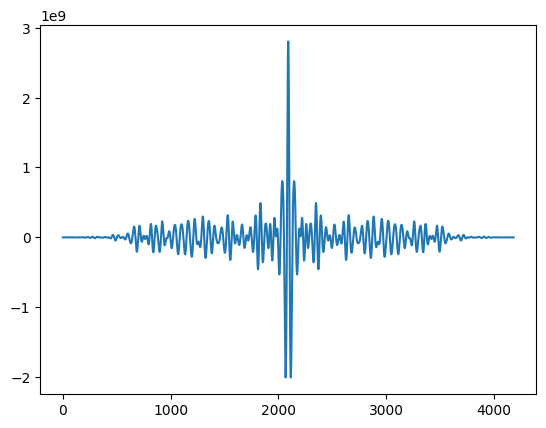

In [17]:
#get and plot autocorrelation of jerk for ankles, y dimension, of first misclassified Ballet Jazz piece
anklecorry_jer = (np.correlate(missBJazz[0].jerk[13][:,1], missBJazz[0].jerk[13][:,1], mode='full') + 
             np.correlate(missBJazz[0].jerk[14][:,1], missBJazz[0].jerk[14][:,1], mode='full')) / 2

plt.plot(anklecorry_jer)

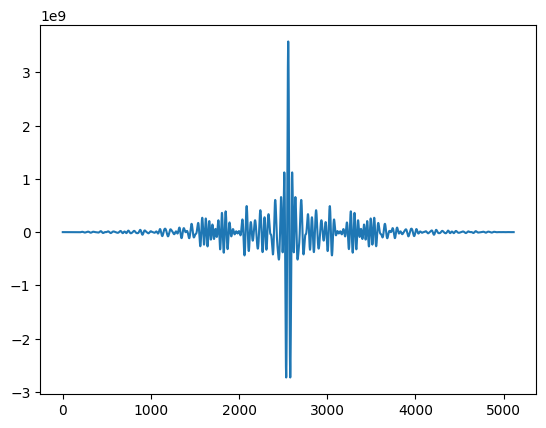

In [20]:
#get and plot autocorrelation of jerk for ankles, y dimension, of first correctly classified Ballet Jazz piece
anklecorry_jer = (np.correlate(HitBJazz[0].jerk[13][:,1], HitBJazz[0].jerk[13][:,1], mode='full') + 
             np.correlate(HitBJazz[0].jerk[14][:,1], HitBJazz[0].jerk[14][:,1], mode='full')) / 2

plt.plot(anklecorry_jer)

In [25]:
#look at the features of the misclassified Ballet Jazz pieces
testset.loc[testset.id.isin(yprob_misBJazz.id)]

,Expandedness,Expandedness_std,Expandednessvel,Expandednessvel_std,Expandednessacc,Expandednessacc_std,Asym_RL_vel,Asym_RL_acc,Asym_RL_jer,Asym_RL_vel_std,...,Contracorr_Relb_Lknee_prominencej2,Contracorr_Relb_Lknee_prominencej3,Contracorr_Relb_Lknee_prominencej_std,Contracorr_Lelb_Rknee_heightjer,Contracorr_Lelb_Rknee_prominencej1,Contracorr_Lelb_Rknee_prominencej2,Contracorr_Lelb_Rknee_prominencej3,Contracorr_Lelb_Rknee_prominencej_std,id,Genre
1609,952.230629,103.339482,1173.811693,590.516327,5529.458983,2822.475105,-3101.460326,-3842.680385,-18763.210259,13.561335,...,7.749144e+08,6.417610e+08,3.189269e+08,1.187765e+08,9.508543e+08,7.796116e+08,6.957601e+08,1.061593e+08,gJB_sFM_cAll_d09_mJB2_ch17,Ballet Jazz
1583,986.565303,106.354552,1250.544711,716.203115,6256.392835,3838.150549,979.998271,-8376.755982,7664.762826,5.987970,...,1.379766e+09,9.206970e+08,3.159570e+08,6.021521e+08,1.457539e+09,1.285451e+09,1.222143e+09,9.946194e+07,gJB_sFM_cAll_d07_mJB4_ch05,Ballet Jazz
1579,1016.357632,99.647915,1285.371478,587.623914,5784.954412,2807.437497,2195.687077,1578.601247,1954.705135,6.754464,...,9.035397e+08,7.964862e+08,8.472218e+07,1.002533e+09,1.734618e+09,1.686987e+09,1.495129e+09,1.035124e+08,gJB_sFM_cAll_d08_mJB3_ch11,Ballet Jazz
1587,1048.961981,107.692128,1234.471461,737.767102,5619.424194,3698.488138,9465.520424,-1080.890634,1052.127688,34.725294,...,1.543689e+09,1.448671e+09,5.126360e+07,4.751784e+08,1.018493e+09,8.528029e+08,7.857072e+08,9.783448e+07,gJB_sFM_cAll_d08_mJB1_ch09,Ballet Jazz
